# Importan Librerías

In [371]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

# Definición de Funciones

In [372]:
def predict(num_prediction, model, data, look_back, scaler):
    prediction_list = data[-look_back:]
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [373]:
def predict_dates(num_prediction):
    last_date = dataset['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).strftime("%Y-%m-%d").tolist()

    return prediction_dates

In [374]:
def inversa_logaritmo(train):

  exp = lambda y: 10 ** y
  vfunc = np.vectorize(exp)

  train_inverse = vfunc(train)

  return train_inverse

# Creación punto de montaje

In [375]:
root = '/content/temp_drive'

In [376]:
drive.mount(root)

Drive already mounted at /content/temp_drive; to attempt to forcibly remount, call drive.mount("/content/temp_drive", force_remount=True).


In [377]:
%cd "{root}/MyDrive/monografia/Salidas"

/content/temp_drive/MyDrive/monografia/Salidas


# Carga Objetos

## Dataset

### Carga Dataset

In [378]:
dataset = df_Coins_Close = pd.read_csv("dataframe_bitcoin_preprocesado.csv", sep=';')

In [379]:
bitcoinClose = df_Coins_Close[["Close","Date"]]
bitcoinClose.set_index("Date", inplace=True)

### Transformaciones Dataset

In [380]:
#Reshape
Close_data = bitcoinClose.values
Close_data = Close_data.reshape((-1,1))

In [381]:
#Escalamiento de los datos
scaler = MinMaxScaler()
scaler.fit(Close_data)

MinMaxScaler()

In [382]:
data = scaler.transform(Close_data)

## Modelo

### Carga del modelo

In [383]:
model = joblib.load('modelo_bitcoinClose_LSTM.pkl')

# Predicción

## Llamado funciones

In [384]:
look_back = 7
num_prediction = 15
forecast = predict(num_prediction, model, data, look_back, scaler)
forecast_dates = predict_dates(num_prediction)

## Inverse

In [385]:
forecast_inv = scaler.inverse_transform(forecast.reshape(-1, 1))

In [386]:
forecast_usd = inversa_logaritmo(forecast_inv)

In [387]:
Close_data_usd = inversa_logaritmo(Close_data)

# Visualización

In [388]:
from datetime import timedelta

In [389]:
date_x = np.concatenate((bitcoinClose.index[-look_back*40:], forecast_dates), axis=0)
df_date_x = pd.DataFrame(date_x,columns=['Date'])
df_date_x['Date'] = pd.to_datetime(df_date_x['Date'], format='%Y-%m-%d')

#df_date_x['Date'] = df_date_x['Date'] + timedelta(days=30)
month_year = pd.to_datetime(df_date_x['Date']).dt.to_period('M')
month_year = month_year.dt.strftime('%Y-%m')

In [390]:
month_year = month_year.unique()

In [391]:
import math

size = look_back*40
step = math.ceil((size+num_prediction)/len(month_year))

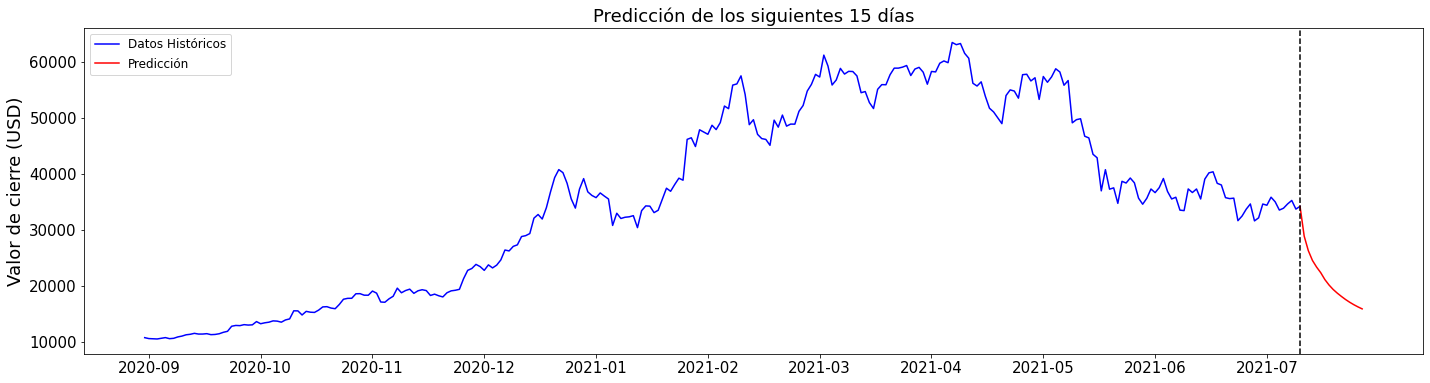

In [392]:
fig = plt.figure(figsize=(24,6))

plt.plot(bitcoinClose.index[-size:],Close_data_usd[-size:],label = 'Datos Históricos', color='blue')
plt.plot(forecast_dates,forecast_usd,label = 'Predicción', color='red')

plt.xticks(range(1,(size+num_prediction),step), month_year, fontsize=15)
plt.axvline(x=size-1,color="black", linestyle="--")
plt.legend(loc='upper left',fontsize=12)

plt.title(f"Predicción de los siguientes {num_prediction} días", fontsize=18)
plt.ylabel("Valor de cierre (USD)", fontsize=18)
plt.yticks(fontsize=15)
plt.savefig("Predicción.jpg", bbox_inches='tight')

plt.show()